In [2]:
%load_ext autoreload
%autoreload 2

import bz2
import json
import re
import random
import sys
import os
import bz2
import time
import pandas as pd
import numpy as np
from functools import partial
import seaborn as sns
from helpers import *

import bz2
import json
import csv

import seaborn as sns
from helpers import PERSONALITY_ATTRS
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('ggplot')

from ipywidgets import widgets, interactive
from io import StringIO
import math
import plotly.express as px

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
liwc_df = pd.read_csv('data/top_1000_output_1.csv')

In [4]:
liwc_df.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
690,Q6789172,"Originally, my love besides football was plan...",897,23.61,17.95,69.23,10.48,4.35,0.89,5.24,...,10.48,0.0,0.67,0.0,0.0,1.11,0.0,2.68,0.89,0.67


In [5]:
personality_df = predict_personality(liwc_df)

In [6]:
with open('data/local_only/top-1000-wikidata-occupation-merged_1639495842765.json', 'r', encoding='utf-8') as f:
    wikidata_json = json.load(f)

In [7]:
wikidata_json['Q357994']

{'item': 'Q357994',
 'itemLabel': 'Roberto Martínez',
 'genderLabel': 'male',
 'citizenshipLabel': 'Spain',
 'dateOfBirth': '1973-07-13T00:00:00Z',
 'occupationLabel': 'association football player'}

In [8]:
df1 = pd.concat([liwc_df, personality_df], axis=1)
wikidata_df = pd.DataFrame(wikidata_json.values())

premain_df = df1.merge(wikidata_df, left_on='Source (A)', right_on='item', how='left')
premain_df.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,item,itemLabel,genderLabel,citizenshipLabel,languageLabel,religionLabel,ethnicLabel,dateOfBirth,occupationLabel,degreeLabel
732,Q6220673,This journey's a research journey just to mee...,810,27.93,30.0,61.85,5.8,0.37,2.59,2.96,...,Q6220673,John Barilaro,male,Australia,NaN,NaN,NaN,1971-11-14T00:00:00Z,politician,NaN


In [9]:
def de_list(series, columns):
    for col in columns:
        while isinstance(series[col], list):
            series[col] = series[col][0]
    return series

In [10]:
DEFAULT_VALUE = 'no value'

def remove_nan(series, columns):
    for col in columns:
        if ((isinstance(series[col], int) or isinstance(series[col], float)) and math.isnan(series[col])):
            series[col] = DEFAULT_VALUE
    return series

In [11]:
premain_df = premain_df.apply(de_list, columns=premain_df.columns, axis=1)
premain_df = premain_df.apply(remove_nan, columns=premain_df.columns, axis=1)

## Clustering based on personality attributes

In [12]:
COLUMNS_OF_INTEREST = ['item', 'itemLabel', 'genderLabel', 'citizenshipLabel', 'religionLabel', 'religionLabel', 'dateOfBirth', 'occupationLabel', 'degreeLabel'] + PERSONALITY_ATTRS

In [13]:
main_df = premain_df[COLUMNS_OF_INTEREST].copy()
main_df.sample()

,item,itemLabel,genderLabel,citizenshipLabel,religionLabel,religionLabel,dateOfBirth,occupationLabel,degreeLabel,neuroticism,...,cooperation,modesty,sympathy,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness
163,Q971308,Patrick Joseph Toomey,male,United States of America,Catholic Church,Catholic Church,1961-11-17T00:00:00Z,foreign currency trader,no value,0.35948,...,3.839828,0.96584,1.967021,-0.433873,2.394652,0.683367,1.742156,0.251518,-0.854504,0.949899


In [20]:
def dget_country_info(qid):
    entity = get_wiki_entity(qid)
    iso = get_iso_code(qid)
    return {'name': str(entity.label), 'iso': str(iso)}

def dnumber_of_clusters(labels):
    return len(np.unique(labels))

def dclustering_percentage_score(labels):
    score = 0
    for val in np.unique(labels):
        number_of_vals = len(labels[labels == val])
        if number_of_vals > score:
            score = number_of_vals
    return (len(labels) - score

def dkinda_binary_search_for_epsilon(
    df, 
    cluster_columns, 
    iterations=20,
    clustering_score_function=number_of_clusters
):
    print('Searching for best EPSILON for DBSCAN!')
    lower_eps = 1
    lower_score = clustering_score_function(lower_eps)
            
    upper_eps = 20
    upper_score = clustering_score_function(upper_eps)

    best_eps = lower_eps
    best_score = lower_score

    for i in range(iterations):
        mid_eps = (lower_eps + upper_eps) / 2.0
        mid_clusters = DBSCAN(eps=mid_eps).fit(df[PERSONALITY_ATTRS])
        mid_score = clustering_score_function(mid_clusters.labels_)
        print(f'{"eps:":5}{mid_eps:5}\t score: {mid_score}')

        if mid_score > best_score:
            best_eps = mid_eps
            best_score = mid_score
            
        mid_plus = mid_eps + (upper_eps - mid_eps) * 0.1
        mid_minus = mid_eps - (mid_eps - lower_eps) * 0.1

        mid_plus_test = DBSCAN(eps=mid_plus).fit(df[PERSONALITY_ATTRS])
        mid_minus_test = DBSCAN(eps=mid_minus).fit(df[PERSONALITY_ATTRS])
        
        mid_plus_score = clustering_score_function(mid_plus_test)
        mid_minus_score = clustering_score_function(mid_minus_test)

        if mid_plus_score > mid_minus_score:
            lower_eps = mid_eps
            lower_score = mid_score
        else:
            upper_eps = mid_eps
            upper_score = mid_score
    return best_eps

SyntaxError: invalid syntax (<ipython-input-20-84b4ff6aca5a>, line 17)

Searching for best EPSILON for DBSCAN!
eps:  10.5	 score: 1
eps:  5.75	 score: 2
eps: 3.375	 score: 2
eps: 2.1875	 score: 3
eps: 2.78125	 score: 2
eps: 2.484375	 score: 2
eps: 2.3359375	 score: 3
eps: 2.26171875	 score: 3
eps: 2.224609375	 score: 3
eps: 2.2060546875	 score: 3
eps: 2.19677734375	 score: 3
eps: 2.192138671875	 score: 3
eps: 2.1898193359375	 score: 3
eps: 2.18865966796875	 score: 3
eps: 2.188079833984375	 score: 3
eps: 2.1877899169921875	 score: 3
eps: 2.1876449584960938	 score: 3
eps: 2.187572479248047	 score: 3
eps: 2.1875362396240234	 score: 3
eps: 2.1875181198120117	 score: 3
Best EPSILON:	2.1875


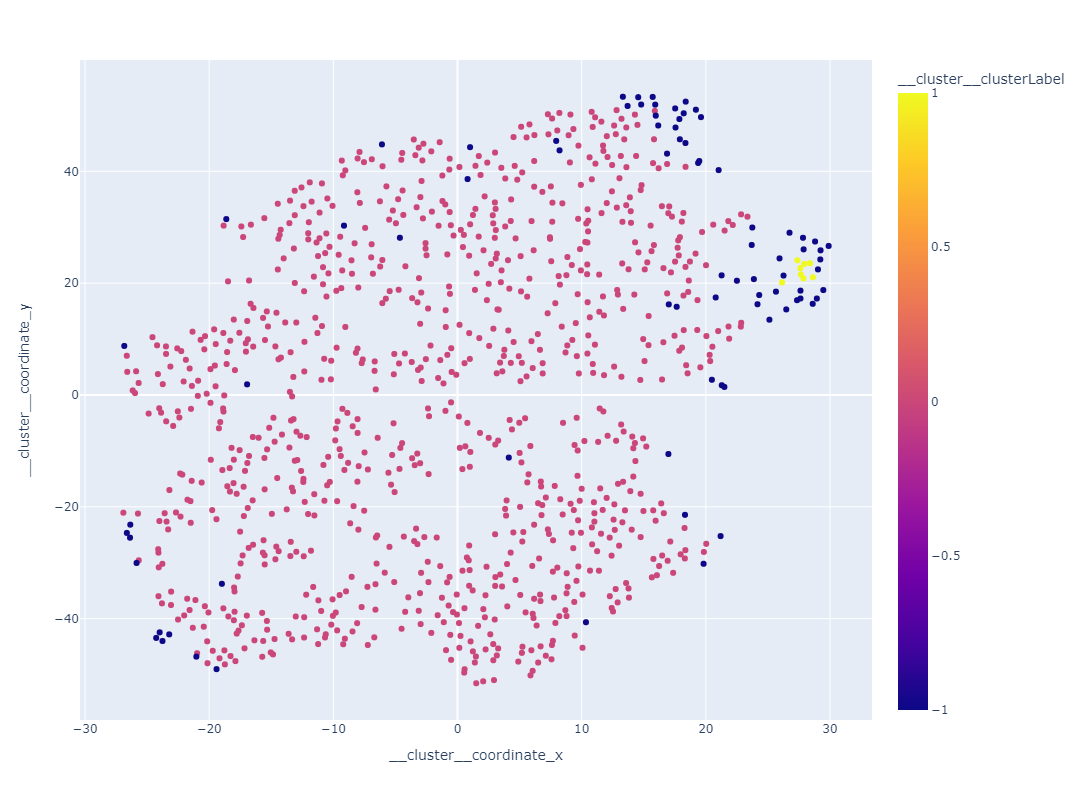

In [36]:
from helpers import clustering_percentage_score

scatter_plot_clusters(
    df=main_df, 
    cluster_columns=PERSONALITY_ATTRS, 
    hover_name='itemLabel',
    hover_data=[
        'genderLabel', 
        'citizenshipLabel', 
        'occupationLabel', 
        'degreeLabel', 
        'dateOfBirth'
    ]
)

In [ ]:
# main_df = main_df.head(100).copy()

In [ ]:
persattrs = main_df[PERSONALITY_ATTRS]
main_df[PERSONALITY_ATTRS] = (persattrs - persattrs.mean()) / persattrs.std()

In [ ]:
clustering = DBSCAN(eps=2).fit(main_df[PERSONALITY_ATTRS])

In [ ]:
def percentage_score(arr):
    score = 0
    for val in np.unique(arr):
        tmp = len(arr[arr == val])
        if tmp > score:
            score = tmp
    return main_df.shape[0] - score

In [ ]:
lower_score = 1
lower_eps = 1
upper_score = 1
upper_eps = 13

for i in range(20):
    mid_eps = (lower_eps + upper_eps) / 2.0
    test = DBSCAN(eps=mid_eps).fit(main_df[PERSONALITY_ATTRS])
    clusters = np.unique(test.labels_)
    mid_score = len(clusters)
    mid_score = percentage_score(test.labels_)
    mid_score = len(test.labels_[test.labels_ == -1])
    mid_score = 1_000_000 - (mid_score - 0.1 * main_df.shape[0]) ** 2
    print(f'{"eps:":5}{mid_eps:5}\tnumber of clusters: {mid_score}\tnumber of clusters: {len(clusters)}')
    
    mid_plus = mid_eps + (upper_eps - mid_eps) * 0.1
    mid_minus = mid_eps - (mid_eps - lower_eps) * 0.1
    
    mid_plus_test = DBSCAN(eps=mid_plus).fit(main_df[PERSONALITY_ATTRS])
    mid_minus_test = DBSCAN(eps=mid_minus).fit(main_df[PERSONALITY_ATTRS])
    
    mid_plus_score = len(np.unique(mid_plus_test.labels_))
    mid_plus_score = percentage_score(mid_plus_test.labels_)
    mid_plus_score = len(mid_plus_test.labels_[mid_plus_test.labels_ == -1])
    mid_plus_score = 1_000_000 - (mid_plus_score - 0.1 * main_df.shape[0]) ** 2
    
    mid_minus_score = len(np.unique(mid_minus_test.labels_))
    mid_minus_score = percentage_score(mid_minus_test.labels_)
    mid_minus_score = len(mid_minus_test.labels_[mid_minus_test.labels_ == -1])
    mid_minus_score = 1_000_000 - (mid_minus_score - 0.1 * main_df.shape[0]) ** 2
    
    print(f'plus: {mid_plus_score}\tminus: {mid_minus_score}')
    
    if mid_plus_score > mid_minus_score:
        print('plus')
        lower_eps = mid_eps
        lower_score = mid_score
    else:
        print('minus')
        upper_eps = mid_eps
        upper_score = mid_score

In [ ]:
# clustering = DBSCAN(eps=1.9375).fit(main_df[PERSONALITY_ATTRS])
# clustering = DBSCAN(eps=2.2890625).fit(main_df[PERSONALITY_ATTRS])
clustering = DBSCAN(eps=3.1328125).fit(main_df[PERSONALITY_ATTRS])

# clustering = DBSCAN(eps=1.48046875).fit(main_df[PERSONALITY_ATTRS])
# clustering = DBSCAN(eps=1.421875).fit(main_df[PERSONALITY_ATTRS])

In [ ]:
clustering.labels_

In [ ]:
coordinates = TSNE().fit_transform(main_df[PERSONALITY_ATTRS])
# coordinates = TSNE().fit_transform(clustering.labels_.reshape(-1, 1))

In [ ]:
main_df['clusterLabel'] = clustering.labels_

In [ ]:
main_df['coordinate_x'] = coordinates[:, 0]
main_df['coordinate_y'] = coordinates[:, 1]

In [ ]:
fig = px.scatter(
    main_df, 
    x='coordinate_x', 
    y='coordinate_y', 
    hover_name='itemLabel', 
#     hover_data=['genderLabel', 'citizenshipLabel', 'religionLabel', 'occupationLabel', 'degreeLabel', 'dateOfBirth'], 
    hover_data=['genderLabel', 'citizenshipLabel', 'occupationLabel', 'degreeLabel', 'dateOfBirth'],
    color = 'clusterLabel', 
    size_max=60
)
fig.update_layout(
     height=800)
fig.show()

## Clustering based on word categories

In [ ]:
WORD_COLUMNS = list(liwc_df.columns)[2:]

In [ ]:
print(WORD_COLUMNS)

In [ ]:
COLUMNS_OF_INTEREST = ['item', 'itemLabel', 'genderLabel', 'citizenshipLabel', 'religionLabel', 'dateOfBirth', 'occupationLabel', 'degreeLabel'] + WORD_COLUMNS

In [ ]:
main_df = premain_df[COLUMNS_OF_INTEREST].copy()
main_df.sample()

In [ ]:
lower_score = 1
lower_eps = 1
upper_score = 1
upper_eps = 13

for i in range(20):
    mid_eps = (lower_eps + upper_eps) / 2.0
    test = DBSCAN(eps=mid_eps).fit(main_df[WORD_COLUMNS])
    clusters = np.unique(test.labels_)
    mid_score = len(clusters)
    mid_score = percentage_score(test.labels_)
    print(f'{"eps:":5}{mid_eps:5}\tnumber of clusters: {mid_score}\tnumber of clusters: {len(clusters)}')
    
    mid_plus = mid_eps + (upper_eps - mid_eps) * 0.1
    mid_minus = mid_eps - (mid_eps - lower_eps) * 0.1
    
    mid_plus_test = DBSCAN(eps=mid_plus).fit(main_df[WORD_COLUMNS])
    mid_minus_test = DBSCAN(eps=mid_minus).fit(main_df[WORD_COLUMNS])
    
    mid_plus_score = len(np.unique(mid_plus_test.labels_))
    mid_plus_score = percentage_score(mid_plus_test.labels_)
    mid_minus_score = len(np.unique(mid_minus_test.labels_))
    mid_minus_score = percentage_score(mid_minus_test.labels_)
    print(f'plus: {mid_plus_score}\tminus: {mid_minus_score}')
    
    if mid_plus_score > mid_minus_score:
        print('plus')
        lower_eps = mid_eps
        lower_score = mid_score
    else:
        print('minus')
        upper_eps = mid_eps
        upper_score = mid_score

In [ ]:
clustering = DBSCAN(eps=8.5).fit(main_df[WORD_COLUMNS])
# clustering = DBSCAN(eps=9.056640625).fit(main_df[WORD_COLUMNS])

In [ ]:
coordinates = TSNE().fit_transform(main_df[WORD_COLUMNS])
# coordinates = TSNE().fit_transform(clustering.labels_.reshape(-1, 1))

In [ ]:
main_df['clusterLabel'] = clustering.labels_

In [ ]:
main_df['coordinate_x'] = coordinates[:, 0]
main_df['coordinate_y'] = coordinates[:, 1]

In [ ]:
main_df[main_df['genderLabel'] == 'male'].shape

In [ ]:
main_df[main_df['genderLabel'] == 'female'].shape

In [ ]:
anders = (main_df['genderLabel'] == 'male') & (main_df['genderLabel'] == 'female')
noters = ~anders
main_df[noters].shape

In [ ]:
from plotly.validators.scatter.marker import SymbolValidator

SYMBOL_COLUMN_NAME = 'genderLabel'

raw_symbols = SymbolValidator().values
unique_list = main_df[SYMBOL_COLUMN_NAME].unique()
print(len(unique_list))

symbol_map = dict()
for index, val in enumerate(unique_list):
    symbol_map[val] = raw_symbols[index]
    
symbol_list = []
for index, row in main_df.iterrows():
    symbol_list.append(symbol_map[row[SYMBOL_COLUMN_NAME]])

In [ ]:
fig = px.scatter(
    main_df, 
    x='coordinate_x', 
    y='coordinate_y', 
    hover_name='itemLabel', 
    hover_data=['genderLabel', 'citizenshipLabel', 'religionLabel', 'occupationLabel', 'degreeLabel', 'dateOfBirth'], 
    color = 'clusterLabel',
    symbol = symbol_list,
    size_max=60
)
fig.update_layout(
     height=800)
fig.show()

In [ ]:
import plotly.graph_objects as go

def multi_scatter(column_name):
    # Build figure
    fig = go.Figure()

    # Add scatter trace with medium sized markers
    fig.add_trace(
        go.Scatter(
            mode='markers',
            x=main_df['coordinate_x'],
            y=main_df['coordinate_y'],
            marker=dict(
                color='LightSkyBlue',
                size=120,
                line=dict(
                    color='MediumPurple',
                    width=12
                )
            ),
            showlegend=False
        )
    )

    # Add trace with large marker
#     fig.add_trace(
#         go.Scatter(
#             mode='markers',
#             x=[2],
#             y=[4.5],
#             marker=dict(
#                 color='LightSkyBlue',
#                 size=120,
#                 line=dict(
#                     color='MediumPurple',
#                     width=12
#                 )
#             ),
#             showlegend=False
#         )
#     )

    fig.show()

In [ ]:
multi_scatter('asd')